In [54]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import nibabel as nib
import psutil
%matplotlib inline
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize



from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import ndimage

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [3]:
flies = ['fly_087', 'fly_089', 'fly_094', 'fly_095', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101',
 'fly_105']

In [44]:
brains = {}
for fly in flies:
    try:
        file = os.path.join(dataset_path, fly, 'warp', 'glm_Z-applied-meanbrain.nii')
        #file = os.path.join(dataset_path, fly, 'warp', 'corr_Z_neg-applied-meanbrain.nii')
        #file = os.path.join(dataset_path, fly, 'func_0', 'corr', '20201020_corr_Y.nii')
        #file = os.path.join(dataset_path, fly, 'warp', 'corr_Y-applied-meanbrain.nii')
        brains[fly] = np.asarray(nib.load(file).get_data(), dtype='float32')/1
        print(fly)
    except:
        print(fly + '_failed')

fly_087
fly_089
fly_094
fly_095
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


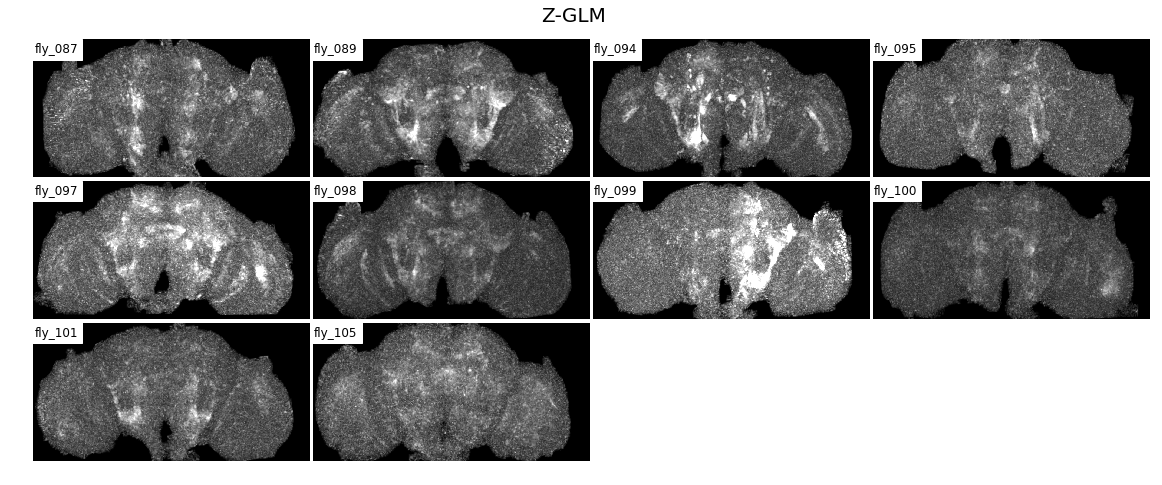

In [45]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=.05)

for i,fly in enumerate(flies):
    grid[i].imshow(np.max(np.abs(np.nan_to_num(brains[fly])),axis=-1).T,cmap='gray',vmin=0,vmax=.0001)
    grid[i].axis('off')
    grid[i].text(x=4,y=50,s=fly,fontsize=12,backgroundcolor='white')
    #if i == 0:
        #scalebar = ScaleBar(6.5*10**-7, location='upper right')
        #grid[i].add_artist(scalebar)
plt.suptitle(x=.5, y=.84, t='Z-GLM', fontsize=20)

for i in range(12):
    grid[i].axis('off')


save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [36]:
to_avg = []
for fly in flies:
    to_avg.append(np.abs(np.nan_to_num(brains[fly])))

In [37]:
meanbrain = np.mean(np.asarray(to_avg),axis=0)

In [38]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201022_analysis_corrs/20201022_top10_corr_Z-neg_mean.nii"

In [39]:
nib.Nifti1Image(meanbrain, np.eye(4)).to_filename(save_file)

# Mean maps

In [47]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging"

In [49]:
file = os.path.join(dataset_path, '20201013_analysis', '20201020_top10_glm_Y_mean.nii')
Y_glm_map = np.asarray(nib.load(file).get_data(), dtype='float32')/1

file = os.path.join(dataset_path, '20201013_analysis', '20201020_top10_glm_Z_mean.nii')
Z_glm_map = np.asarray(nib.load(file).get_data(), dtype='float32')/1

file = os.path.join(dataset_path, '20201022_analysis_corrs', '20201022_top10_corr_Y_mean.nii')
Y_corr_map = np.asarray(nib.load(file).get_data(), dtype='float32')/1

file = os.path.join(dataset_path, '20201022_analysis_corrs', '20201022_top10_corr_Z-abs_mean.nii')
Z_corr_map = np.asarray(nib.load(file).get_data(), dtype='float32')/1

file = os.path.join(dataset_path, 'anat_templates', 'luke.nii')
anatomy = np.asarray(nib.load(file).get_data(), dtype='float32')/1

In [134]:
### GLM ###

Z_glm_flat = np.max(Z_glm_map, axis=-1)
Y_glm_flat = np.max(Y_glm_map, axis=-1)

diff_glm_vol = Y_glm_map-Z_glm_map
maxs = np.max(diff_glm_vol, axis=-1).ravel()
mins = np.min(diff_glm_vol, axis=-1).ravel()
idx_to_replace = np.where((np.abs(mins)>maxs))
maxs[idx_to_replace] = mins[idx_to_replace]
maxs.shape = Y_glm_map.shape[:2]
diff_glm_map = maxs.copy()

In [132]:
### CORRS ###

Z_corr_flat = np.max(Z_corr_map, axis=-1)
Y_corr_flat = np.max(Y_corr_map, axis=-1)

diff_corr_vol = Y_corr_map-Z_corr_map
maxs = np.max(diff_corr_vol, axis=-1).ravel()
mins = np.min(diff_corr_vol, axis=-1).ravel()
idx_to_replace = np.where((np.abs(mins)>maxs))
maxs[idx_to_replace] = mins[idx_to_replace]
maxs.shape = Y_corr_map.shape[:2]
diff_corr_map = maxs.copy()

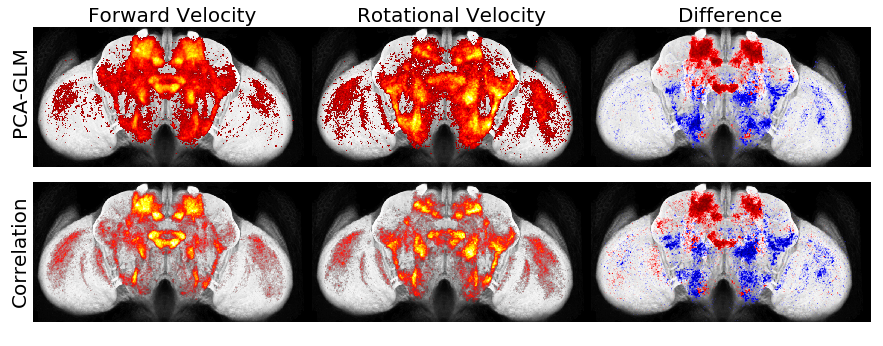

In [195]:
plt.figure(figsize=(15,5.7))

plt.subplot(2,3,1)
plt.axis('off')
plt.title('Forward Velocity',fontsize=20)
plt.imshow(np.max(anatomy, axis=-1).T,cmap='gray')
alphas = Normalize(0.000019, 0.00002, clip=True)(Y_glm_flat)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(0.000003, .00008)(Y_glm_flat)
cmap = plt.cm.hot
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(np.swapaxes(colors,0,1))

plt.subplot(2,3,2)
plt.axis('off')
plt.title('Rotational Velocity',fontsize=20)
plt.imshow(np.max(anatomy, axis=-1).T,cmap='gray')
alphas = Normalize(0.000019, 0.00002, clip=True)(Z_glm_flat)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(.00001, .00006)(Z_glm_flat)
cmap = plt.cm.hot
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(np.swapaxes(colors,0,1))

plt.subplot(2,3,3)
plt.axis('off')
plt.title('Difference',fontsize=20)
plt.imshow(np.max(anatomy, axis=-1).T,cmap='gray')
alphas = Normalize(.00001, .00002, clip=True)(np.abs(diff_glm_map))
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-.00004, .00004)(diff_glm_map)
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(np.swapaxes(colors,0,1))

#############
### CORRS ###
#############

plt.subplot(2,3,4)
plt.axis('off')
plt.imshow(np.max(anatomy, axis=-1).T,cmap='gray')
alphas = Normalize(0.02, .04, clip=True)(Y_corr_flat)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(.02, .07)(Y_corr_flat)
cmap = plt.cm.hot
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(np.swapaxes(colors,0,1))

plt.subplot(2,3,5)
plt.axis('off')
plt.imshow(np.max(anatomy, axis=-1).T,cmap='gray')
alphas = Normalize(.02, .04, clip=True)(Z_corr_flat)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(0.023, .064)(Z_corr_flat)
cmap = plt.cm.hot
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(np.swapaxes(colors,0,1))

plt.subplot(2,3,6)
plt.axis('off')
plt.imshow(np.max(anatomy, axis=-1).T,cmap='gray')
alphas = Normalize(.01, .02, clip=True)(np.abs(diff_corr_map))
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-.035, .035)(diff_corr_map)
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
plt.imshow(np.swapaxes(colors,0,1))

plt.subplots_adjust(wspace=0, hspace=0)
plt.text(x=-2130,y=-450,s='PCA-GLM',rotation=90,fontsize=20)
plt.text(x=-2130,y=100,s='Correlation',rotation=90,fontsize=20)


save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

(array([  1029.,  12679.,  83782., 130211., 146801., 107464.,  31330.,
          7564.,   3082.,    346.]),
 array([-0.03325394, -0.02563251, -0.01801108, -0.01038964, -0.00276821,
         0.00485322,  0.01247465,  0.02009609,  0.02771752,  0.03533895,
         0.04296038]),
 <a list of 10 Patch objects>)

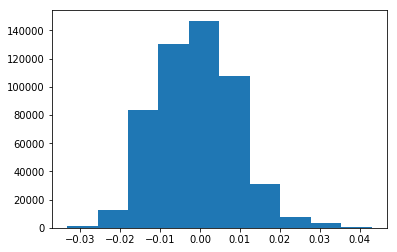

In [169]:
plt.hist(diff_corr_map.ravel())

(array([166451.,  56640., 130151.,  92273.,  46042.,  15804.,   8694.,
          5525.,   2352.,    356.]),
 array([0.        , 0.00738405, 0.01476811, 0.02215216, 0.02953621,
        0.03692027, 0.04430432, 0.05168838, 0.05907243, 0.06645648,
        0.07384054]),
 <a list of 10 Patch objects>)

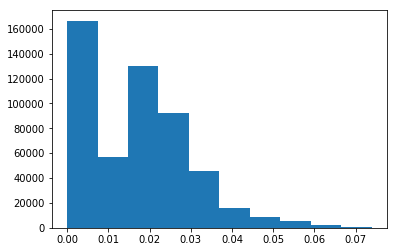

In [138]:
plt.hist(Y_corr_flat.ravel())